# Michelson Interferometer simulation for FQNET PM test

This is a quick and dirty simulation written to understand the FQNET PM testing. This is a prelimanry stage code and does not import the external module as it should. This is not a good practice, but done for the speed.



In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import time

The Source class represents LASER. 

It is written poorly here, and better impletmentaion can be found in the Parts.py under utilities

In [2]:
class Source:
    '''
    Source class represents the input wave source
    Currently only supports continuous wave (CW) laser with assumning 
    infinite coherence length.
    
    natural scale is defined as
    
    Length : nm
    time : ns
    phase : radians
    amp : To user's relavant amp (Watts to oscilloscope reading will be a future support)
    
    params:
    waveLength : default value = 1550 nm
    phaseLaser : default = 0 
    amp : amplitude of the EM wave set at 1
    
    __init__ defines some relavant constants
    
    Methods:
    
    wave:
    wave will assume a laser that has propagated throug space to infinite x
    and starting to measure the effect and evolution at t 
    
    Since the detector position is fixed and the associated scale x (wavelength) 
    is small in demensions of time, most of the time the wave is treated with 
    only variable t.
    
    phase: 
    
    phase takes in the same two arguement x and t in nm and ns and returns 
    current phase of the laser
    
    out: 
    
    out is the main method that can be used to pass the wave source for other operations.
    
    
    '''
    
    def __init__(self, wave_length = 1550, phase_laser = 0, amp = 1):
        
        c = 3*10**8
        self.wave_length = wave_length 
        self.phase_laser = phase_laser
        self.amp = 1
        self.k = 2 * np.pi / (wave_length)
        self.omega = 2 * np.pi * c / wave_length
            
    def wave (self, x, t):
        
        return self.amp*np.sin( self.k *x + self.omega * t + self.phase_laser)
    
    #def p_modulate(self, newphase, period = 0):
        
     #   if period ==0: self.phase_laser = newphase
        
      #  else: self.phase_laser = newphase
            
    def phase (self, x, t):
        
        return (self.k * x +self.omega * t + self.phase_laser)%(2*np.pi)
    
    def out(self, t, x = 0, phase_change = 0):
        
        return self.amp*np.sin( self.k *x + self.omega * t + self.phase_laser + phase_change )

In place of properly written phase modulator object, This pm_function replaces PM object and can only serve as square pi phase modulation driven with period of 2*dt

In [3]:
def pm_function(t, dt):
    if dt == 0:
        return 0 
    if t < dt:
        return 0
    else:
        if (t//dt)%2 ==0:
            return 0
        else:
            return np.pi

The maximum terriblness is reached here with this extremely horribly written michenson function that serves as a michelson interferometer with effective total pathlength difference **dl** and the input signal modulated by periodicity of **2*dt**

The units are taken to be __nm, ns__

Our photodetector has __rise time__ of __12.5 ps__. The inter for loop samples the wave 500 times within the 12.5 ps and outputs the average power. This in next iteration of code should be handled under Detector object.

The total simulation time is now given in units of 12.5 ps. The output of the oscilloscope is sampled at __5GHz__ giving additional averaging and sampling rate at 0.2 ns. This averaging is not taken to account but will be adjusted to run a secon program where the averaging happens oer 0.2 ns intead of 12.5ps. 

__n_sample__ : number of samples to take during the averaging period 

__t_avg__  : sets the signal power averaging time

__t_tot__  : sets total simulation time

This function can take a while so I would be careful about setting these params


In [4]:
def michelson(dl, dt, n_sample, t_avg, t_tot):
    
    
    out = []
    time = []
    l = 1* 10**9
    l2 = l + dl
    c = 3*10**8
    t=20
    
    n_tot_sample = t_tot // t_avg
    delta_t = t_avg / n_sample

    for j in range (int(n_tot_sample)):
        
        amp = []
        
        for i in range(int(n_sample)):
            t = delta_t + t
            t1 = t-l/c
            t2 = t-l2/c
            amp.append((0.5*Laser.out(t1, phase_change = pm_function(t1, dt)) + 
                       0.5*Laser.out(t2, phase_change = pm_function(t2, dt)))**2)
                        

        time.append(t)
        out.append(np.mean(amp))
            
    return time, out

Initializing the laser object (Nothing interesting about this.. just creates as CW laser with 1550 nm wavelength)

In [5]:
Laser = Source()

Fixing the length difference of the interferometer, and the other simulation parameters with exception of PM driving period

In [6]:
dl = 2*10**9
n_sample = 200
t_avg = 12.5*10**(-3)
t_tot = 200
print ('Length difference of the two arm:', dl/10**9, 'm')

Length difference of the two arm: 2.0 m


In [7]:
dt = dl/(3*10**8)
print ('travel time difference between two arms of the interferometer: ', dt , 'ns')

travel time difference between two arms of the interferometer:  6.666666666666667 ns


Making the figure pretty

In [8]:
fig_size =plt.rcParams["figure.figsize"]
fig_size[0] = 20
plt.rcParams["figure.figsize"] = fig_size

## Interferometer code testing

### Interferometer without the pm

In [9]:
start_time = time.time()
dt = 0
t_axis, I_dl = michelson(dl, dt , n_sample, t_avg, t_tot)
t_axis, I_lambda_0_5 = michelson (200000.5*1550, dt, n_sample, t_avg, t_tot)
t_axis, I_lambda_n = michelson (200000*1550, dt, n_sample, t_avg, t_tot)
print("--- %s seconds ---" % (time.time() - start_time))


--- 39.205660820007324 seconds ---


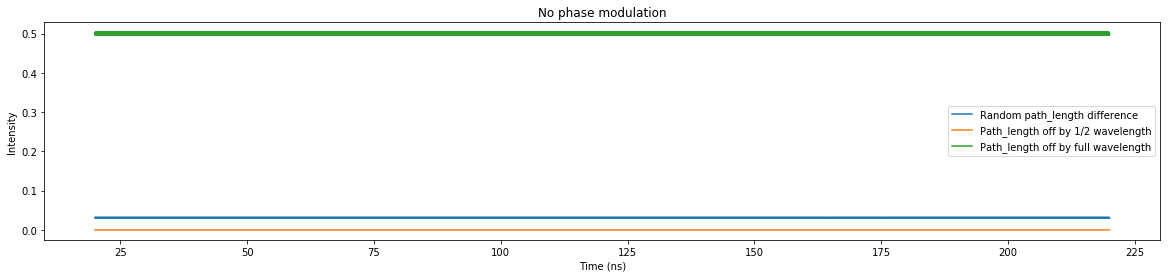

In [10]:
plt.xlabel("Time (ns)")
plt.ylabel("Intensity")
plt.title("No phase modulation")
plt.plot( t_axis , I_dl, label = 'Random path_length difference')
plt.plot(t_axis, I_lambda_0_5, label = 'Path_length off by 1/2 wavelength')
plt.plot (t_axis , I_lambda_n, label = 'Path_length off by full wavelength')
plt.legend()
plt.show()

### Interferometer output intensity as a function of length

For a michelson interferometer, the output intensity of light as a function of length has an analytical solution. 

I ~ 1/2 * E1 ^2 + 1/2 * E2 ^ 2 + E1*E2*cos(k*dl)

This can be compared to the simulation result to check if the simulation is capturing the behavior of the interferometer

In [11]:
def theory(x): return 0.5*0.25 + 0.5*0.25 + 0.25*np.cos((2 * np.pi / (1550))* x)
I_theory = [theory(x) for x in range(10000) ]

Simulation output

In [12]:
I_simulation = []
x = []

for delta_l in range(10000):
    
    _, I_inter = michelson(delta_l, 0 , n_sample, t_avg, 0.2)
    
    x.append(delta_l)
    I_simulation.append(np.mean(I_inter))


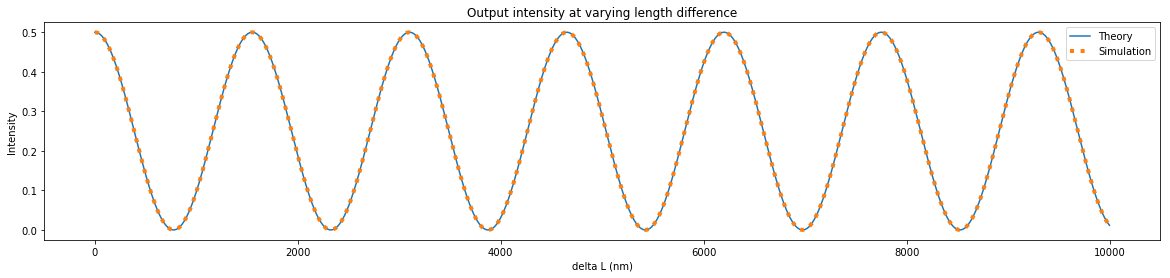

In [13]:
plt.xlabel("delta L (nm)")
plt.ylabel("Intensity")
plt.title("Output intensity at varying length difference")
plt.plot (x, I_theory, label = 'Theory')
plt.plot( x , I_simulation, linestyle=':', linewidth=4, label = 'Simulation')
plt.legend()
plt.show()

## updating dt

### dt = 6.6667 ns (Same as the pathlength difference within 10e-4 ns )

In [13]:
start_time = time.time()
dt = 6.6667
t_axis, I_6_6667 = michelson(dl, dt , n_sample, t_avg, t_tot)
phase_mod_6_6667 = [pm_function(x, dt)/np.pi for x in t_axis]
print("--- %s seconds ---" % (time.time() - start_time))


--- 15.293953895568848 seconds ---


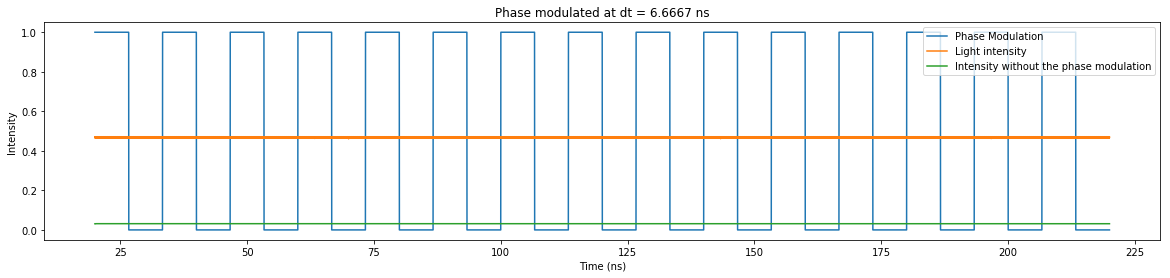

In [14]:
plt.xlabel("Time (ns)")
plt.ylabel("Intensity")
plt.title("Phase modulated at dt = 6.6667 ns")
plt.plot( t_axis , phase_mod_6_6667, label = 'Phase Modulation')
plt.plot (t_axis , I_6_6667, label = 'Light intensity')
plt.plot( t_axis , I_dl, label = 'Intensity without the phase modulation')
plt.legend()
plt.show()

### dt = 6.667 ns (Same as the pathlength difference within 10e-3 ns )

In [15]:
start_time = time.time()
dt = 6.667
t_axis, I_6_667 = michelson(dl, dt , n_sample, t_avg, t_tot)
phase_mod_6_667 = [pm_function(x, dt)/np.pi for x in t_axis]
print("--- %s seconds ---" % (time.time() - start_time))


--- 15.521003007888794 seconds ---


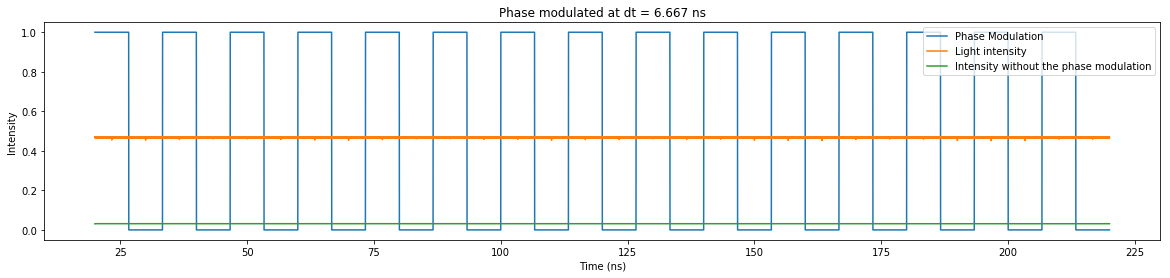

In [16]:
plt.xlabel("Time (ns)")
plt.ylabel("Intensity")
plt.title("Phase modulated at dt = 6.667 ns")
plt.plot( t_axis , phase_mod_6_667, label = 'Phase Modulation')
plt.plot (t_axis , I_6_667, label = 'Light intensity')
plt.plot( t_axis , I_dl, label = 'Intensity without the phase modulation')
plt.legend()
plt.show()

### dt = 6.67 ns (Same as the pathlength difference within 10e-2)

In [17]:
start_time = time.time()
dt =6.67
t_axis, I_6_67 = michelson(dl, dt , n_sample, t_avg, t_tot)
phase_mod_6_67 = [pm_function(x, dt)/np.pi for x in t_axis]
print("--- %s seconds ---" % (time.time() - start_time))


--- 15.735961198806763 seconds ---


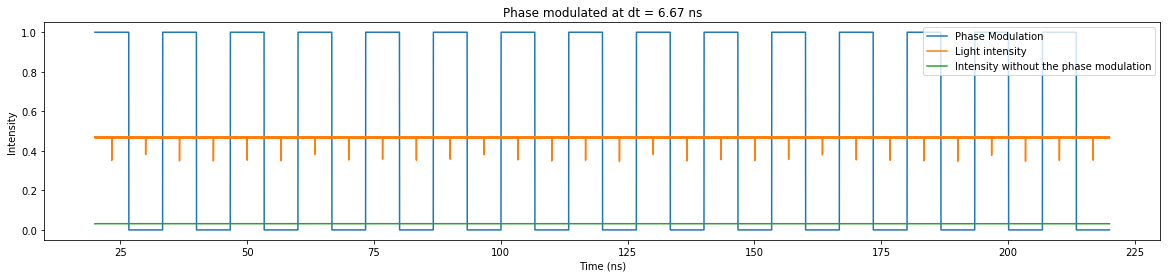

In [18]:
plt.xlabel("Time (ns)")
plt.ylabel("Intensity")
plt.title("Phase modulated at dt = 6.67 ns")
plt.plot( t_axis , phase_mod_6_67, label = 'Phase Modulation')
plt.plot (t_axis , I_6_67, label = 'Light intensity')
plt.plot( t_axis , I_dl, label = 'Intensity without the phase modulation')
plt.legend()
plt.show()

### dt = 6.7 ns (Same as the pathlength difference within 10e-1)

In [19]:
start_time = time.time()
dt =6.7
t_axis, I_6_7 = michelson(dl, dt , n_sample, t_avg, t_tot)
phase_mod_6_7 = [pm_function(x, dt)/np.pi for x in t_axis]
print("--- %s seconds ---" % (time.time() - start_time))


--- 15.559860944747925 seconds ---


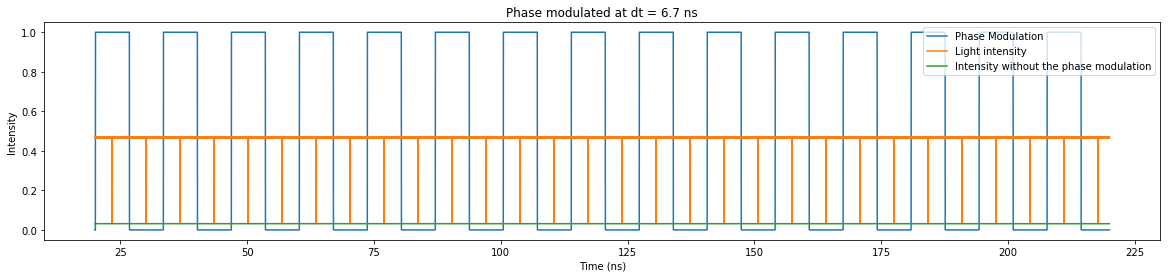

In [20]:
plt.xlabel("Time (ns)")
plt.ylabel("Intensity")
plt.title("Phase modulated at dt = 6.7 ns")
plt.plot( t_axis , phase_mod_6_7, label = 'Phase Modulation')
plt.plot (t_axis , I_6_7, label = 'Light intensity')
plt.plot( t_axis , I_dl, label = 'Intensity without the phase modulation')
plt.legend()
plt.show()

### dt = 7 ns (Same as the pathlength difference within 1 ns)

In [21]:
start_time = time.time()
dt =7
t_axis, I_7 = michelson(dl, dt , n_sample, t_avg, t_tot)
phase_mod_7 = [pm_function(x, dt)/np.pi for x in t_axis]
print("--- %s seconds ---" % (time.time() - start_time))


--- 15.507349014282227 seconds ---


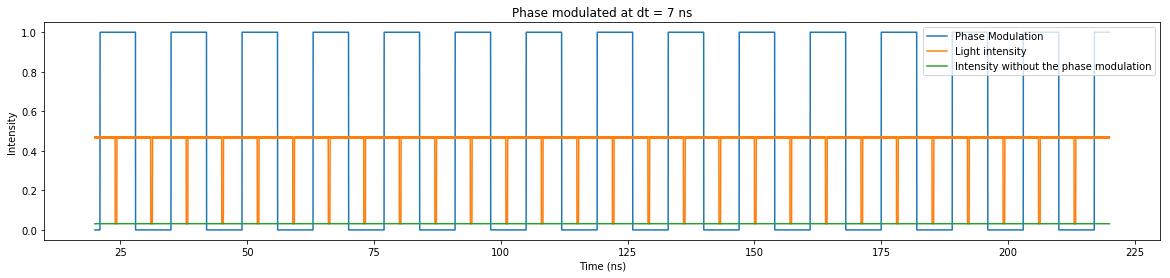

In [22]:
plt.xlabel("Time (ns)")
plt.ylabel("Intensity")
plt.title("Phase modulated at dt = 7 ns")
plt.plot( t_axis , phase_mod_7, label = 'Phase Modulation')
plt.plot (t_axis , I_7, label = 'Light intensity')
plt.plot( t_axis , I_dl, label = 'Intensity without the phase modulation')
plt.legend()
plt.show()

## dt < interferometer dt

### dt = 2 ns 

In [23]:
start_time = time.time()
dt =2
t_axis, I_2 = michelson(dl, dt , n_sample, t_avg, t_tot)
phase_mod_2 = [pm_function(x, dt)/np.pi for x in t_axis]
print("--- %s seconds ---" % (time.time() - start_time))


--- 15.637184143066406 seconds ---


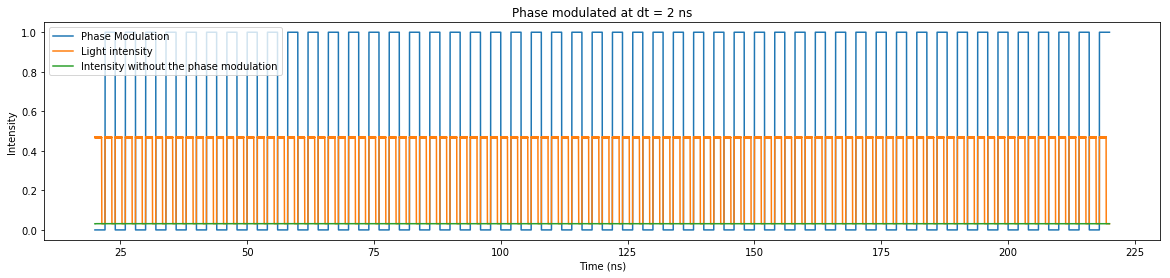

In [24]:
plt.xlabel("Time (ns)")
plt.ylabel("Intensity")
plt.title("Phase modulated at dt = 2 ns")
plt.plot( t_axis , phase_mod_2, label = 'Phase Modulation')
plt.plot (t_axis , I_2, label = 'Light intensity')
plt.plot( t_axis , I_dl, label = 'Intensity without the phase modulation')
plt.legend()
plt.show()

### dt = 3 ns 

In [25]:
start_time = time.time()
dt =3
t_axis, I_3 = michelson(dl, dt , n_sample, t_avg, t_tot)
phase_mod_3 = [pm_function(x, dt)/np.pi for x in t_axis]
print("--- %s seconds ---" % (time.time() - start_time))


--- 15.823846817016602 seconds ---


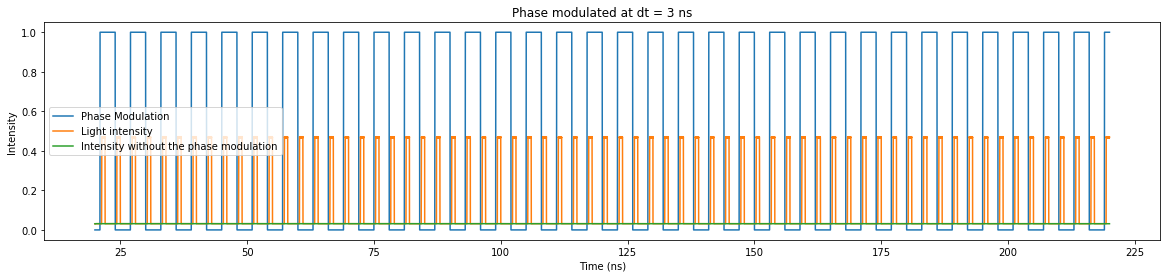

In [26]:
plt.xlabel("Time (ns)")
plt.ylabel("Intensity")
plt.title("Phase modulated at dt = 3 ns")
plt.plot( t_axis , phase_mod_3, label = 'Phase Modulation')
plt.plot (t_axis , I_3, label = 'Light intensity')
plt.plot( t_axis , I_dl, label = 'Intensity without the phase modulation')
plt.legend()
plt.show()

### dt = 4 ns 

In [27]:
start_time = time.time()
dt =4
t_axis, I_4 = michelson(dl, dt , n_sample, t_avg, t_tot)
phase_mod_4 = [pm_function(x, dt)/np.pi for x in t_axis]
print("--- %s seconds ---" % (time.time() - start_time))


--- 15.556236982345581 seconds ---


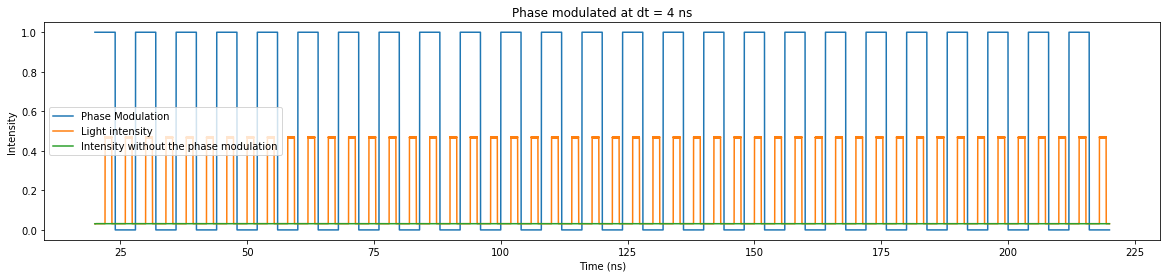

In [28]:
plt.xlabel("Time (ns)")
plt.ylabel("Intensity")
plt.title("Phase modulated at dt = 4 ns")
plt.plot( t_axis , phase_mod_4, label = 'Phase Modulation')
plt.plot (t_axis , I_4, label = 'Light intensity')
plt.plot( t_axis , I_dl, label = 'Intensity without the phase modulation')
plt.legend()
plt.show()

### dt = 5 ns 

In [29]:
start_time = time.time()
dt =5
t_axis, I_5 = michelson(dl, dt , n_sample, t_avg, t_tot)
phase_mod_5 = [pm_function(x, dt)/np.pi for x in t_axis]
print("--- %s seconds ---" % (time.time() - start_time))


--- 15.48809289932251 seconds ---


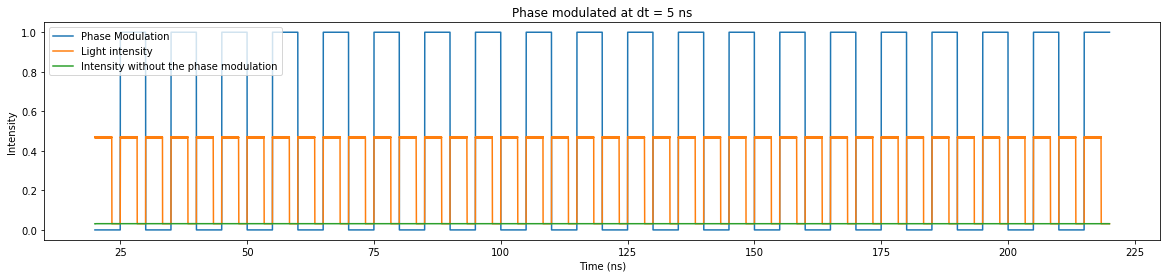

In [30]:
plt.xlabel("Time (ns)")
plt.ylabel("Intensity")
plt.title("Phase modulated at dt = 5 ns")
plt.plot( t_axis , phase_mod_5, label = 'Phase Modulation')
plt.plot (t_axis , I_5, label = 'Light intensity')
plt.plot( t_axis , I_dl, label = 'Intensity without the phase modulation')
plt.legend()
plt.show()

### dt =  6 ns 

In [31]:
start_time = time.time()
dt =6
t_axis, I_6 = michelson(dl, dt , n_sample, t_avg, t_tot)
phase_mod_6 = [pm_function(x, dt)/np.pi for x in t_axis]
print("--- %s seconds ---" % (time.time() - start_time))


--- 15.713510751724243 seconds ---


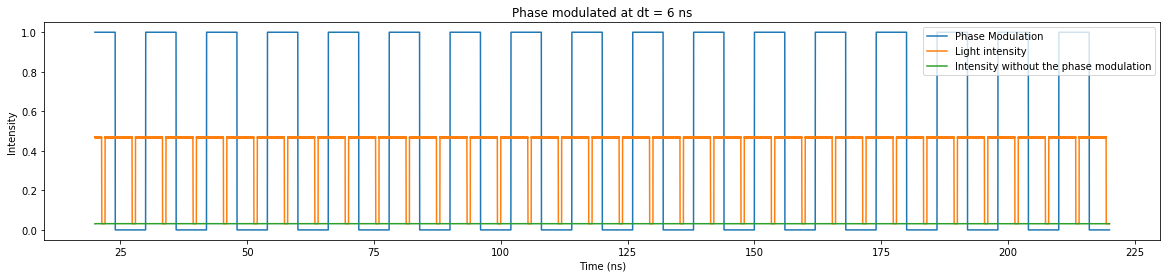

In [32]:
plt.xlabel("Time (ns)")
plt.ylabel("Intensity")
plt.title("Phase modulated at dt = 6 ns")
plt.plot( t_axis , phase_mod_6, label = 'Phase Modulation')
plt.plot (t_axis , I_6, label = 'Light intensity')
plt.plot( t_axis , I_dl, label = 'Intensity without the phase modulation')
plt.legend()
plt.show()

## dt > interferometer dt

### dt = 8 ns 

In [33]:
start_time = time.time()
dt =8
t_axis, I_8 = michelson(dl, dt , n_sample, t_avg, t_tot)
phase_mod_8 = [pm_function(x, dt)/np.pi for x in t_axis]
print("--- %s seconds ---" % (time.time() - start_time))


--- 15.415344715118408 seconds ---


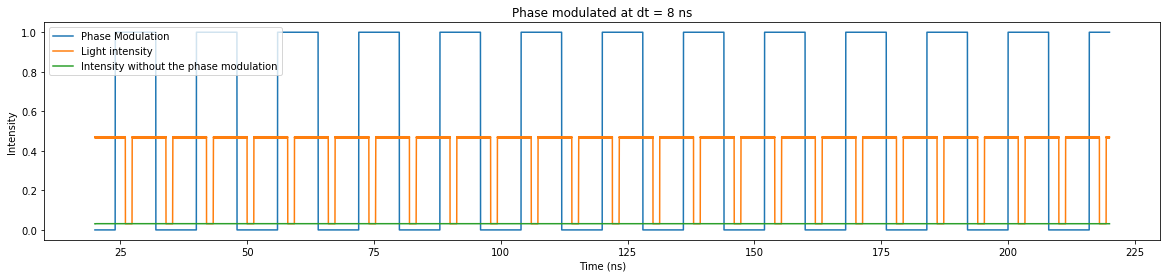

In [34]:
plt.xlabel("Time (ns)")
plt.ylabel("Intensity")
plt.title("Phase modulated at dt = 8 ns")
plt.plot( t_axis , phase_mod_8, label = 'Phase Modulation')
plt.plot (t_axis , I_8, label = 'Light intensity')
plt.plot( t_axis , I_dl, label = 'Intensity without the phase modulation')
plt.legend()
plt.show()

### dt = 9 ns 

In [35]:
start_time = time.time()
dt =9
t_axis, I_9 = michelson(dl, dt , n_sample, t_avg, t_tot)
phase_mod_9 = [pm_function(x, dt)/np.pi for x in t_axis]
print("--- %s seconds ---" % (time.time() - start_time))


--- 15.71665620803833 seconds ---


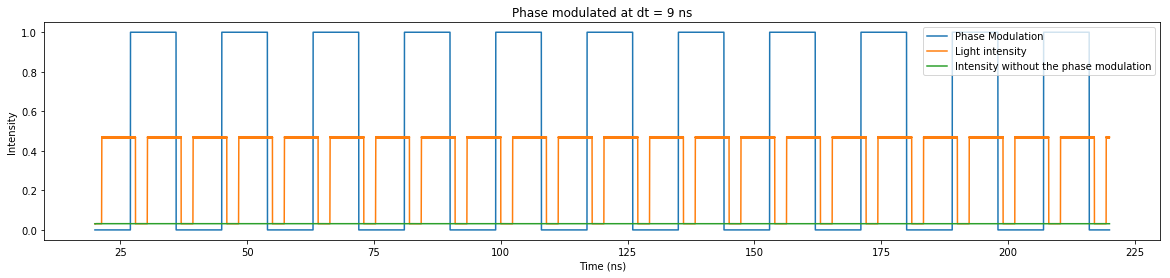

In [36]:
plt.xlabel("Time (ns)")
plt.ylabel("Intensity")
plt.title("Phase modulated at dt = 9 ns")
plt.plot( t_axis , phase_mod_9, label = 'Phase Modulation')
plt.plot (t_axis , I_9, label = 'Light intensity')
plt.plot( t_axis , I_dl, label = 'Intensity without the phase modulation')
plt.legend()
plt.show()

### dt = 10 ns 

In [37]:
start_time = time.time()
dt = 10
t_axis, I_10 = michelson(dl, dt , n_sample, t_avg, t_tot)
phase_mod_10 = [pm_function(x, dt)/np.pi for x in t_axis]
print("--- %s seconds ---" % (time.time() - start_time))


--- 15.470304012298584 seconds ---


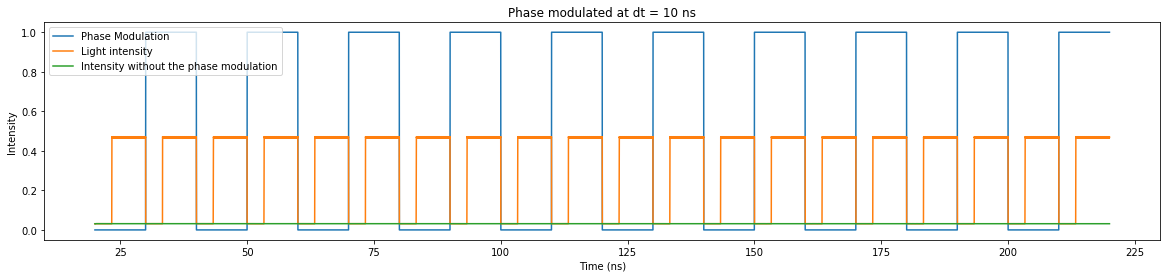

In [38]:
plt.xlabel("Time (ns)")
plt.ylabel("Intensity")
plt.title("Phase modulated at dt = 10 ns")
plt.plot( t_axis , phase_mod_10, label = 'Phase Modulation')
plt.plot (t_axis , I_10, label = 'Light intensity')
plt.plot( t_axis , I_dl, label = 'Intensity without the phase modulation')
plt.legend()
plt.show()

## Some concluding remarks

* Not sure why there is some coincidence where the power is attenuated all the way to zero
* Our signal looks more like the simulation with some sort of low pass filter applies. Not sure why that would be.
* Wouldn't it be easier to detect average power change using DC detector?